# Coding 3
Nishanth Alladi (nalladi2), Ethan Cook (elcook3), (davyji2)

In [134]:
from skmisc.loess import loess, loess_outputs
from sklearn.cluster import KMeans
import numpy as np
import csv
from scipy.interpolate import splev, interp1d

/Users/nishu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Part 1

In [135]:
data = [[], []]
with open('Coding3_Data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        data[0].append(row[0])
        data[1].append(row[1])
data[0] = np.array(data[0][1:], dtype='float64')
data[1] = np.array(data[1][1:], dtype='float64')

data = np.asarray(data)

In [136]:
def lcv(y, y_hat, S):
    return sum(np.square((y - y_hat) / (1 - S))) / len(x)

In [137]:
def gcv(y, y_hat, S):
    return sum(np.square((y - y_hat) / (1 - (1 / len(x)) * sum(S)))) / len(x)


In [138]:
spans = np.arange(0.2, 0.95, 0.05)
lcvs = []
gcvs = []
x, y = data[0], data[1]
for span in spans:
    loess_model = loess(x, y)
    loess_model.model.span = span
    loess_model.fit()
    S = loess_model.outputs.diagonal
    y_hat = loess_model.outputs.fitted_values
    
    lcvs.append(lcv(y, y_hat, S))
    gcvs.append(gcv(y, y_hat, S))
    
lcvs = np.array(lcvs)
gcvs = np.array(gcvs)
best_span_lcv = spans[np.argmin(lcvs)]
best_span_gcv = spans[np.argmin(gcvs)]

### Task 2

In [139]:
print('LCVs in order from 0.20 ... 0.90', lcvs)
print('GCVs in order from 0.20 ... 0.90', gcvs)

LCVs in order from 0.20 ... 0.90 [12.4159107   2.2414735   1.50297981  1.25917471  1.19037993  1.15681212
  1.12565234  1.17966375  1.17946416  1.25091383  1.55356226  1.63617462
  1.76453363  1.97609351  2.03510792]
GCVs in order from 0.20 ... 0.90 [2.11016184 1.48920563 1.19010984 1.17442296 1.1025399  1.06250346
 1.04183288 1.11884055 1.11926881 1.18058478 1.51909081 1.62742935
 1.74454909 1.92569596 1.9798204 ]


### Task 3

In [140]:
print('Best span chosen by LCV: ', best_span_lcv)
print('Best span chosen by GCV: ', best_span_gcv)

Best span chosen by LCV:  0.49999999999999994
Best span chosen by GCV:  0.49999999999999994


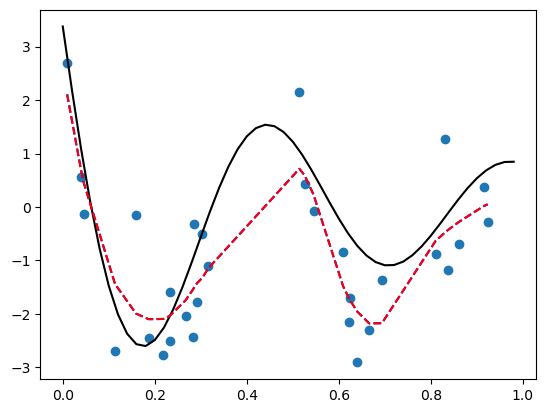

In [153]:
import matplotlib.pyplot as plt

plt.plot(x, y, 'o')

range_ = np.arange(0.0, 1, 0.02)
plt.plot(range_, np.sin(12 * (range_ + 0.2)) / (range_ + 0.2), 'k')

loess_model = loess(x, y)
loess_model.model.span = best_span_lcv
loess_model.fit()
y_hat_lcv = loess_model.outputs.fitted_values
    
loess_model = loess(x, y)
loess_model.model.span = best_span_gcv
loess_model.fit()
y_hat_gcv = loess_model.outputs.fitted_values

plt.plot(x, y_hat_lcv, 'b--')
plt.plot(x, y_hat_gcv, 'r--')

In [228]:
np.random.seed(280)
# my uin last 4 are 0280
# setting numpy seed since algorithms below use np seed

## Part II

In [195]:
data = np.loadtxt(open("Sales_Transactions_Dataset_Weekly.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,53))
 
x = data - np.mean(data, axis=1, keepdims=True)

In [196]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if outside.any():
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if oleft.any():
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if oright.any():
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if inside.any():
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

### Obtaining NCS coefficients in B

In [210]:
# obtaining NCS coefficients in B
weeks = np.arange(1, 53, 1)
F = ns(weeks, df=10)
F = F[:,1:]
F -= np.mean(F, axis=0)

BT = np.linalg.inv(F.T @ F) @ F.T @ x.T
B = BT.T

### Clustering using matrix B

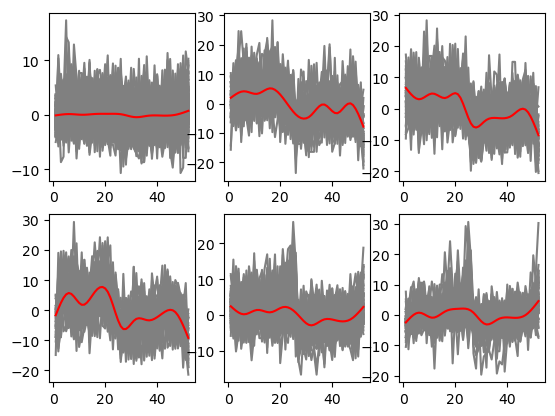

In [260]:
# Clustering using Matrix B
n_clusters = 6
B_clusters = KMeans(n_clusters = n_clusters, random_state = 280).fit(B).labels_
for i in range(n_clusters):
    plt.subplot(2, 3, i+1)
    B_cluster_i = B[B_clusters == i]
    b = np.mean(B_cluster_i, axis = 0)
    timeseries_center = F @ b
    timeseries = x[B_clusters == i]
    for j in range(len(timeseries)):
        plt.plot(weeks, timeseries[j], 'grey')
    plt.plot(weeks, timeseries_center, 'r')

### Clustering using matrix X

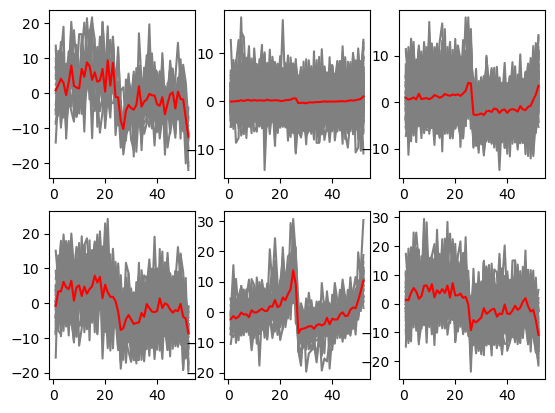

In [262]:
# Clustering using Matrix X
n_clusters = 6
x_clusters = KMeans(n_clusters = n_clusters, random_state = 280).fit(x).labels_
for i in range(n_clusters):
    plt.subplot(2, 3, i+1)
    x_cluster_i = x[x_clusters == i]
    timeseries_center = np.mean(x_cluster_i, axis = 0)
    for j in range(len(x_cluster_i)):
        plt.plot(weeks, x_cluster_i[j], 'grey')
    plt.plot(weeks, timeseries_center, 'r')